## Conditional random walk graph GAN training
Enron

In [1]:
from eggen import utils
from eggen.eggen_shadow import *

import tensorflow as tf
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import pickle

/home/wesleyjtann/miniconda3/envs/eggen/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# ## Load data
# """ Entire set of email data """
data = pd.read_csv('./data/Enron_messages.csv')
print("Data chunk size: " ,len(data))

#### Dept data (conditions)
cond_list = pd.read_csv('./data/Enron_DeptList.csv') #, sep=" ", header=None)
cond_list.columns = ['ID', 'DEPT']
cond_list = cond_list.values


import networkx as nx
import nxviz as nv

G = nx.from_pandas_edgelist(data, 'Sender ID', 'Receiver ID') #, edge_attr=['SENDER DE


## Preparing data
Adjtraining = nx.adjacency_matrix(G)
Adjtraining = sp.csr_matrix(Adjtraining, dtype='float64')
_A_obs = Adjtraining
_A_obs = _A_obs + _A_obs.T # 
_A_obs[_A_obs > 1] = 1 # Max value of 1 

""" Reduce input graph to a subgraph where only the nodes in largest n_components are kept. """ 
lcc = utils.largest_connected_components(_A_obs) # 
_A_obs = _A_obs[lcc,:][:,lcc] # 
_N = _A_obs.shape[0] # 

""" Get the subset of cond_list before reindexing from 0 """
ind_nonlcc = np.delete(np.arange(len(cond_list)), lcc)
lcc_condlist = np.delete(cond_list, ind_nonlcc, 0)
print("Length of cond_list", len(cond_list))

print("**** N nodes {:}, E edges: {:}, K classes: {:} ****".format(_N,
                                                                  np.count_nonzero(_A_obs.todense())/2,
                                                                  len(np.unique(lcc_condlist[:,1]))
                                                                  ))

#### Separate the edges into train, test, validation
val_share = 0.1
test_share = 0.05
seed = 2020 #  
"""
Split the edges of the adjacency matrix into train, validation and test edges and randomly samples equal amount of validation and test non-edges. 
"""
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False) 

## EGGen
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()


Data chunk size:  38388
Selecting 1 largest connected components
Length of cond_list 156
**** N nodes 154, E edges: 1843.0, K classes: 3 ****


[0 1 2]
[59 25 70]


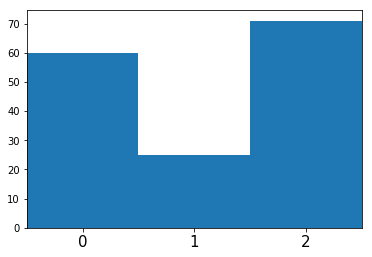

154

In [3]:
# unique_conds, conds_counts = np.unique(subset_condlist[:,1], return_counts=True)
unique_conds, conds_counts = np.unique(lcc_condlist[:,1], return_counts=True)
print(unique_conds)
print(conds_counts)

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    
import matplotlib.pyplot as plt
bins = range(len(unique_conds)+1)
# plt.hist(subset_condlist[:,1], bins)  
plt.hist(cond_list[:,1], bins)  
bins_labels(bins, fontsize=15)
# plt.title("ENRON")
# plt.savefig('./image/enron.png')
plt.show()

# np.sum([59, 25, 70])
np.sum(conds_counts)

In [4]:
#### Parameters
""" Adjustable parameters for training. """ 
# setting GPU id 
gpu_id = 0
# setting the number of nodes
_N = _A_obs.shape[0]
# setting the length of random walks
rw_len = 16 #
# setting the training data batch size
batch_size = 128 #
# getting the number of departments
n_conds=len(np.unique(lcc_condlist[:,1]))
print("n_conds: ", n_conds)
sample_batch = 1000 #

walker = utils.RandomWalker(train_graph, lcc_condlist, rw_len, p=1, q=1, batch_size=batch_size, sample_batch=sample_batch)

n_conds:  3


## Create our generative model 

In [5]:
l2_gen=1e-7; l2_disc=5e-5 #1e-4 
gencond_lay=[10]; gen_lay=[50]; disc_lay=[40] 
lr_gencond=0.01; lr_gen=0.0002; lr_disc=0.0002
gencond_iters=1; gen_iters=1; disc_iters=3
discWdown_size=128; genWdown_size=128 

eggen = EGGen(_N,
rw_len,
walk_generator=walker,
n_conds=n_conds,
condgenerator_layers=gencond_lay,
generator_layers=gen_lay,
discriminator_layers=disc_lay,
W_down_discriminator_size=discWdown_size,
W_down_generator_size=genWdown_size,
batch_size=batch_size,
sample_batch=sample_batch,
condition_dim=n_conds,
gencond_iters=gencond_iters,
gen_iters=gen_iters,
disc_iters=disc_iters,
wasserstein_penalty=10, 
l2_penalty_generator=l2_gen,
l2_penalty_discriminator=l2_disc,
lr_gencond=lr_gencond,
lr_gen=lr_gen,
lr_disc=lr_disc,
noise_dim=16, #32, #
noise_type="Gaussian", #"Uniform", #
temp_start=5.0, #30.0, #10.0, #
min_temperature=0.5,
temperature_decay=1-5e-5,
seed=15, #seed, #
use_gumbel=True,
legacy_generator=False,
gpu_id=gpu_id,
plot_show=False
)

intermediate:  Tensor("Generator/Generator.int_1/Tanh:0", shape=(128, 50), dtype=float32)
h:  Tensor("Generator/Generator.h_1/Tanh:0", shape=(128, 50), dtype=float32)
c:  Tensor("Generator/Generator.c_1/Tanh:0", shape=(128, 50), dtype=float32)
Generator initial_states:  1
Initial cond:  Tensor("Generator/unstack:0", shape=(128, 3), dtype=float32)


In [6]:
""" ===================================================================================== """
model_name = "model_best_31"
print("Model: ", model_name)
saver = tf.train.Saver()
saver.restore(eggen.session, "snapshots_shadow/" + model_name + ".ckpt") # 

Model:  model_best_31
INFO:tensorflow:Restoring parameters from snapshots_shadow/model_best_31.ckpt


## Controlled generation - Markov chain

In [7]:
sample_many, explain_conds = eggen.generate_discrete(1000, conds=True, rw_len=rw_len, reuse=True) 

intermediate:  Tensor("Generator_1/Generator.int_1/Tanh:0", shape=(1000, 50), dtype=float32)
h:  Tensor("Generator_1/Generator.h_1/Tanh:0", shape=(1000, 50), dtype=float32)
c:  Tensor("Generator_1/Generator.c_1/Tanh:0", shape=(1000, 50), dtype=float32)
Generator initial_states:  1
Initial cond:  Tensor("Generator_1/unstack:0", shape=(1000, 3), dtype=float32)


In [8]:
dept_list = unique_conds
dept_list

array([0, 1, 2])

In [9]:
# Initial state distribution
init_distr = [0.9, .05, .05]

# Probabilities matrix (transition matrix)
transitionMatrix = [[0.9,0.1,0.0],[0.1,0.6,0.3],[0.2,0.7,0.1]]

if sum(transitionMatrix[0])+sum(transitionMatrix[1])+sum(transitionMatrix[1]) != 3:
    print("Somewhere, something went wrong. Transition matrix, perhaps?")
else: print("All is gonna be okay, you should move on!! ;)")

All is gonna be okay, you should move on!! ;)


In [10]:
def generate_controltrans(init_distr, transitionMatrix, dept_list, n_samples=10000, rw_len=16):
        
    shadow_walks = np.empty([n_samples, rw_len], dtype=int)

    for sample_shadowwalk in range(n_samples):
        shadow_walk = [] #np.array([], dtype=int)
        walk_start = np.random.choice(dept_list, p=init_distr)

        step = walk_start

        for _ in range(rw_len-1):
        #     print(_)
            if _ == 0:
                shadow_walk.append(walk_start)

            if step == dept_list[0]:
                step = np.random.choice(dept_list,replace=True,p=transitionMatrix[0])
#                 p=intra_dept_prob; q=inter_dept_prob; r=inter_dept_prob
            elif step == dept_list[1]:
                step = np.random.choice(dept_list,replace=True,p=transitionMatrix[1])
#                 p=inter_dept_prob; q=intra_dept_prob; r=inter_dept_prob
            else:
                step = np.random.choice(dept_list,replace=True,p=transitionMatrix[2])
#                 p=inter_dept_prob; q=inter_dept_prob; r=intra_dept_prob

#             step = np.random.choice(dept_list, p=[p, q, r])
            shadow_walk.append(step)

    #     print(shadow_walk)

        shadow_walks[sample_shadowwalk] = shadow_walk

    return np.array(shadow_walks)

In [11]:
trans_shadow1 = generate_controltrans(init_distr, transitionMatrix, dept_list, n_samples=1000, rw_len=16)
unique_conds, conds_counts1 = np.unique(trans_shadow1, return_counts=True)
print(conds_counts1)
print(conds_counts1 / np.sum(conds_counts1))

trans_shadow2 = generate_controltrans(init_distr=[0.05, .05, .9], 
                                       transitionMatrix=[[0.9,0.1,0.0],[0.1,0.6,0.3],[0.0,0.1,0.9]], 
                                       dept_list=dept_list, n_samples=1000, rw_len=16)
unique_conds, conds_counts2 = np.unique(trans_shadow2, return_counts=True)
print(conds_counts2)
print(conds_counts2 / np.sum(conds_counts2))

[10200  4356  1444]
[0.6375  0.27225 0.09025]
[ 1818  3031 11151]
[0.113625  0.1894375 0.6969375]


In [12]:
def controlled_generation(init_distr, transitionMatrix, multiplier, controlgen_iter, control_dept_list, condition_dim, n_samples=10000, rw_len=16):
#     control_conds_discrete = np.random.choice(control_dept_list, size=[n_samples,rw_len], p=[p, q, r])
    control_conds_discrete = generate_controltrans(init_distr, transitionMatrix, control_dept_list, n_samples, rw_len)
    conds = tf.one_hot(control_conds_discrete, condition_dim) # (n_samples, rw_len, n_conds)
    control_samplemany, control_conds = eggen.generate_discrete(n_samples, conds=conds, rw_len=rw_len, reuse=True)
    
    start_time = time.time()
    control_samples = []
    for _ in range(controlgen_iter): 
        if (_+1) % 1000 == 0:
            print(_+1)
#             control_conds_discrete = np.random.choice(control_dept_list, size=[n_samples,rw_len], p=[p, q, r])
            control_conds_discrete = generate_controltrans(init_distr, transitionMatrix, control_dept_list, n_samples, rw_len)
            conds = tf.one_hot(control_conds_discrete, condition_dim) # (n_samples, rw_len, n_conds)
            control_samplemany, control_conds = eggen.generate_discrete(n_samples, conds=conds, rw_len=rw_len, reuse=True)
        control_samples.append(control_samplemany.eval({eggen.tau: 0.5}))
    print("--- %s seconds ---" % (time.time() - start_time))
    
    control_rws = np.array(control_samples).reshape([-1, rw_len])
    print("control_rws: ", control_rws.shape)
    control_scrmatrix = utils.score_matrix_from_random_walks(control_rws, _N).tocsr()
    
    """ Compute control graph statistics"""
    control_graph = utils.graph_from_scores(control_scrmatrix,  _A_obs.sum()*multiplier)
    
    print("EO: ", utils.edge_overlap(_A_obs.toarray(), control_graph)/_A_obs.sum()*multiplier)
    
    G_control = nx.from_numpy_matrix(control_graph)

    # Assign attribute to G_control
    for row in lcc_condlist:
        G_control.nodes[row[0]]['attr'] = row[1]
        
    return G_control

In [24]:
G_control1 = controlled_generation(init_distr=[0.9, 0.05, 0.05], 
                                   transitionMatrix=[[0.98,0.01,0.01],[0.1,0.6,0.3],[0.0,0.1,0.9]], 
                                   multiplier=1, controlgen_iter=100, control_dept_list=dept_list, 
                                   condition_dim=n_conds, rw_len=4)

G_control2 = controlled_generation(init_distr=[0.05, 0.05, 0.9], 
                                   transitionMatrix=[[0.9,0.1,0.0],[0.1,0.6,0.3],[0.03,0.02,0.95]], 
                                   multiplier=1, controlgen_iter=100, control_dept_list=dept_list, 
                                   condition_dim=n_conds, rw_len=4)

G_control3 = controlled_generation(init_distr=[0.05, 0.9, 0.05], 
                                   transitionMatrix=[[0.9,0.1,0.0],[0.1,0.7,0.2],[0.0,0.1,0.9]],
                                   multiplier=1, controlgen_iter=100, control_dept_list=dept_list, 
                                   condition_dim=n_conds, rw_len=4)

intermediate:  Tensor("Generator_5/Generator.int_1/Tanh:0", shape=(10000, 50), dtype=float32)
h:  Tensor("Generator_5/Generator.h_1/Tanh:0", shape=(10000, 50), dtype=float32)
c:  Tensor("Generator_5/Generator.c_1/Tanh:0", shape=(10000, 50), dtype=float32)
Generator initial_states:  1
Initial cond:  Tensor("Generator_5/unstack:0", shape=(10000, 3), dtype=float32)
--- 1.1919398307800293 seconds ---
control_rws:  (1000000, 4)
EO:  0.3819858925664677
intermediate:  Tensor("Generator_6/Generator.int_1/Tanh:0", shape=(10000, 50), dtype=float32)
h:  Tensor("Generator_6/Generator.h_1/Tanh:0", shape=(10000, 50), dtype=float32)
c:  Tensor("Generator_6/Generator.c_1/Tanh:0", shape=(10000, 50), dtype=float32)
Generator initial_states:  1
Initial cond:  Tensor("Generator_6/unstack:0", shape=(10000, 3), dtype=float32)
--- 1.1583938598632812 seconds ---
control_rws:  (1000000, 4)
EO:  0.4286489419424851
intermediate:  Tensor("Generator_7/Generator.int_1/Tanh:0", shape=(10000, 50), dtype=float32)
h:  

In [25]:
G_orig = nx.from_numpy_matrix(_A_obs.todense())

# Assign attribute to G_orig
for row in lcc_condlist:
    G_orig.nodes[row[0]]['attr'] = row[1]
    
    
orig_colormap = []
for node in G_orig:
#     print(node)
    if nx.get_node_attributes(G_orig,'attr')[node] == unique_conds[0]: 
        orig_colormap.append('red')
    elif nx.get_node_attributes(G_orig,'attr')[node] == unique_conds[1]:  
        orig_colormap.append('blue')      
    elif nx.get_node_attributes(G_orig,'attr')[node] == unique_conds[2]:  
        orig_colormap.append('green')      
    else:
        orig_colormap.append('gray')
        
orig_pos = nx.spring_layout(G_orig, k=.1)      

In [26]:
nice_pos = nx.spring_layout(G_orig)  

# Prepare center points (along circle perimeter) for the clusters
colors = ['green', 'royalblue', 'red'] #, 'orange', 'cyan']

# angs = np.linspace(0, 1*np.pi, 1+len(colors)) #array([0., 1.04719755, 2.0943951 , 3.14159265])
angs = np.array([0.0, 0.5, 2.5, 4.5])

repos = []
rad = .61 #1.1 #3.5     # radius of circle

for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
        
for ea in nice_pos.keys():
    #color = 'black'
    posx = 0
#     print(ea) 
    if lcc_condlist[ea,1] == unique_conds[0]:
        posx = 0
    elif lcc_condlist[ea,1] == unique_conds[1]:
        posx = 1
    elif lcc_condlist[ea,1] == unique_conds[2]:
        posx = 2
    else:
        pass
    nice_pos[ea] += repos[posx]

/home/wesleyjtann/miniconda3/envs/eggen/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


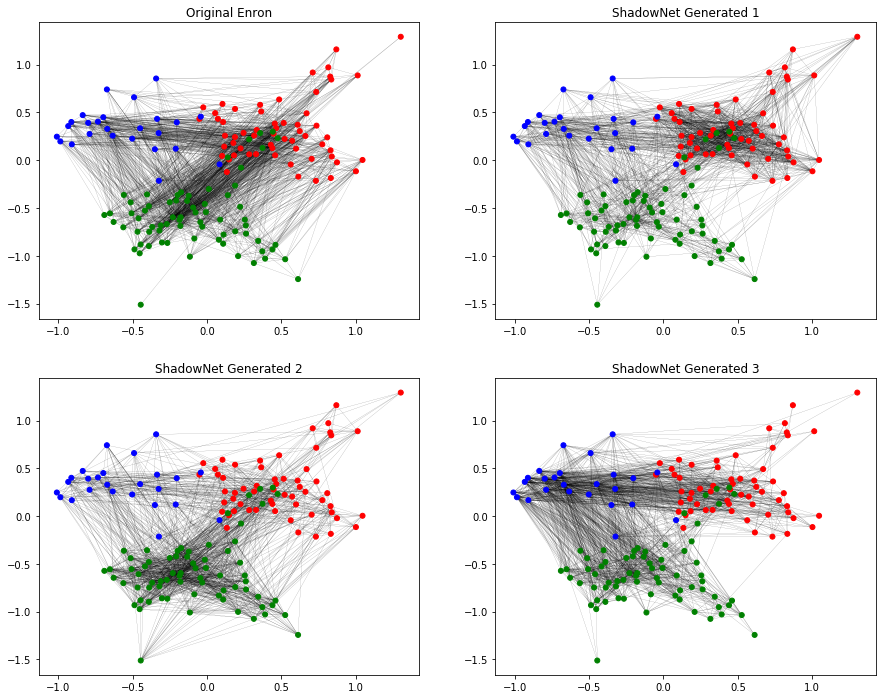

In [27]:
# f = plt.figure(figsize=(15,4))
f = plt.figure(figsize=(15,12))

edgewidth=0.09

ax1 = f.add_subplot(221) #131) #
nx.draw_networkx(G_orig, nice_pos, node_size=25, width=edgewidth, node_color=orig_colormap, with_labels=False)
ax1.title.set_text('Original Enron')

ax2 = f.add_subplot(222) #132) #
nx.draw_networkx(G_control1, nice_pos, node_size=25, width=edgewidth, node_color=orig_colormap, with_labels=False)
ax2.title.set_text('ShadowNet Generated 1')

ax3 = f.add_subplot(223)
nx.draw_networkx(G_control2, nice_pos, node_size=25, width=edgewidth, node_color=orig_colormap, with_labels=False)
ax3.title.set_text('ShadowNet Generated 2')

ax4 = f.add_subplot(224) #133) #
nx.draw_networkx(G_control3, nice_pos, node_size=25, width=edgewidth, node_color=orig_colormap, with_labels=False)
ax4.title.set_text('ShadowNet Generated 3')

# # plt.title("ENRON")
# # plt.savefig('./image/enron_controlgraphs.png')

plt.show()

In [28]:
utils.compute_graph_statistics(nx.to_numpy_array(G_orig))

/home/wesleyjtann/miniconda3/envs/eggen/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'d_max': 88.0,
 'd_min': 1.0,
 'd': 23.935064935064936,
 'LCC': 154,
 'wedge_count': 56302.0,
 'claw_count': 730549.0,
 'triangle_count': 7958,
 'square_count': 19096,
 'power_law_exp': 1.3316448521589244,
 'gini': 0.28058783321941205,
 'rel_edge_distr_entropy': 0.9713587054136178,
 'assortativity': -0.006475126560779397,
 'clustering_coefficient': 0.032679532789723895,
 'n_components': 1,
 'cpl': 2.0735930735930737}

In [29]:
# Controlled Generation 1
utils.compute_graph_statistics(nx.to_numpy_array(G_control1))

{'d_max': 66.0,
 'd_min': 4.0,
 'd': 23.935064935064936,
 'LCC': 154,
 'wedge_count': 55043.0,
 'claw_count': 636994.0,
 'triangle_count': 8985,
 'square_count': 36936,
 'power_law_exp': 1.611755203102574,
 'gini': 0.28825813361895825,
 'rel_edge_distr_entropy': 0.9718035603004979,
 'assortativity': 0.4299837982920312,
 'clustering_coefficient': 0.04231594018154017,
 'n_components': 1,
 'cpl': 2.075036075036075}

In [30]:
# Controlled Generation 2
utils.compute_graph_statistics(nx.to_numpy_array(G_control2))

{'d_max': 82.0,
 'd_min': 3.0,
 'd': 23.935064935064936,
 'LCC': 154,
 'wedge_count': 56456.0,
 'claw_count': 712050.0,
 'triangle_count': 8059,
 'square_count': 24446,
 'power_law_exp': 1.5216172739766636,
 'gini': 0.2919400187441423,
 'rel_edge_distr_entropy': 0.9703785655740803,
 'assortativity': 0.2206702915594743,
 'clustering_coefficient': 0.0339540762586897,
 'n_components': 1,
 'cpl': 2.0497411085646378}

In [31]:
# Controlled Generation 3
utils.compute_graph_statistics(nx.to_numpy_array(G_control3))

{'d_max': 68.0,
 'd_min': 2.0,
 'd': 23.935064935064936,
 'LCC': 154,
 'wedge_count': 59063.0,
 'claw_count': 788637.0,
 'triangle_count': 7921,
 'square_count': 19763,
 'power_law_exp': 1.4379640978994193,
 'gini': 0.3162193205600692,
 'rel_edge_distr_entropy': 0.96484582668368,
 'assortativity': 0.09271079357912841,
 'clustering_coefficient': 0.030131733611281235,
 'n_components': 1,
 'cpl': 2.0697733638910107}